# MNIST with linear optical neural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import scipy
import pyfftw

In [2]:
#MNIST dataset
MNIST_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
MNIST_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

#Dataloaders
train_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=10000, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_test, batch_size=10000, shuffle=False)


In [3]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))
X_train_MNIST = np.squeeze(X_train_MNIST.detach().cpu().numpy())
Y_train_MNIST = Y_train_MNIST.numpy()

X_test_MNIST, Y_test_MNIST = next(iter(test_loader_MNIST))
X_test_MNIST = np.squeeze(X_test_MNIST.detach().cpu().numpy())
Y_test_MNIST = Y_test_MNIST.numpy()

#### Here we try different FFFTs

- On the numpy arrays we just created before.
- Numpy, scipy, cupy, torch

In [4]:
# let's test numpy's FFT 

start_time = time.time()

X_train_FFT_1 = np.fft.fft2(X_train_MNIST, axes=(-2,-1))

end_time = time.time()

npumpy_FFT_time = end_time - start_time

print(f'Time for numpy FFT: {end_time - start_time}')

Time for numpy FFT: 0.6525068283081055


In [5]:
# let's test scipy's FFT

start_time = time.time()

X_train_FFT_2 = scipy.fft.fft2(X_train_MNIST, axes=(-2,-1))

end_time = time.time()

scipy_FFT_time = end_time - start_time

print(f'Time for scipy FFT: {end_time - start_time}')


Time for scipy FFT: 0.16988706588745117


In [7]:
# let's test fftw's FFT, it is natively faster and supports easy multithreading
pyfftw.config.NUM_THREADS = 8

start_time = time.time()
X_train_FFT_3 = pyfftw.interfaces.numpy_fft.fft2(X_train_MNIST, axes=(-2,-1))

end_time = time.time()

fftw_FFT_time = end_time - start_time

print(f'Time for fftw FFT: {end_time - start_time}')

Time for fftw FFT: 0.17046546936035156


In [8]:
# let's test pytorch FFT, it is natively faster and supports easy multithreading

X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_MNIST = X_train_MNIST.to(device)

torch.cuda.synchronize()

start_time = time.time()

X_train_FFT_4 = torch.fft.fft2(X_train_MNIST)

torch.cuda.synchronize()
end_time = time.time()

torch_FFT_time = end_time - start_time

print(f'Time for Torch FFT: {end_time - start_time}')

Time for Torch FFT: 0.6418979167938232


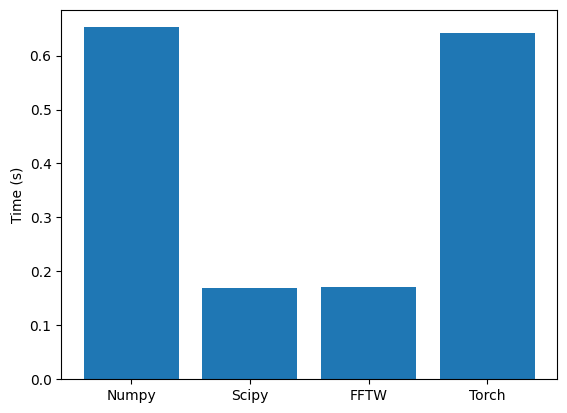

In [9]:
#plotting comparison

time_vec = [npumpy_FFT_time, scipy_FFT_time, fftw_FFT_time, torch_FFT_time]
labels = ['Numpy', 'Scipy', 'FFTW', 'Torch']

plt.bar(labels, time_vec)
plt.ylabel('Time (s)')
plt.show()

In [7]:
class Lin_ONN(nn.Module):
    # Class simulating an optical linear neural network
    def __init__(self, input_size=784, SLM_size=100, output_size=10):
        
        super(Lin_ONN, self).__init__()
        
        # SLM parameters (trainable)
        self.SLM_params = nn.Parameter(torch.rand(size=(SLM_size,SLM_size)) * 2 * torch.pi)  # Phase modulation parameters
        self.SLM_size = SLM_size

    def forward(self, X):
        
        # Apply FFT (forward transform)
        X_fft = torch.fft.fft2(X)
        #print(X_fft.shape)
        #print(self.SLM_params.shape)
        #print(self.SLM_size)
            # Resize using interpolation
        X_fft = F.interpolate(
            X_fft.real, size=(self.SLM_size, self.SLM_size), mode='bilinear', align_corners=False
            ) + 1j * F.interpolate(
        X_fft.imag, size=(self.SLM_size, self.SLM_size), mode='bilinear', align_corners=False
            )   
        # Create the complex exponential for phase modulation (e^i*theta)
        # Apply phase modulation (element-wise multiplication in Fourier domain)

        X_fft = X_fft * torch.exp(1j * self.SLM_params)
        
        # Apply Inverse FFT to bring it back to real space
        X_fft = torch.fft.ifft2(X_fft)
        
        # Now, apply the output layer which is camera detection
        X_fft = torch.abs(X_fft)**2  
        
        # Output projection (you can adapt this based on your task)
        logits = X_fft
        
        return logits

In [8]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))


ONN = Lin_ONN(SLM_size=100)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move input data to the device
X_train_MNIST = X_train_MNIST.to(device)

# Move model to the device
ONN.to(device)

# Measure forward pass time
torch.cuda.synchronize()
start_time = time.time()

# Forward pass
Y = ONN.forward(X_train_MNIST)

torch.cuda.synchronize()
end_time = time.time()

print(f'Forward pass time: {end_time - start_time} seconds')


Forward pass time: 0.47239208221435547 seconds


In [5]:
from scipy.ndimage import zoom

class Lin_ONN_fftw():
    # Class simulating an optical linear neural network
    def __init__(self, input_size=784, SLM_size=100, output_size=10):
        # SLM parameters (trainable)
        self.SLM_params = np.random.rand(SLM_size, SLM_size) * 2 * np.pi  # Phase modulation parameters
        self.SLM_size = SLM_size
        # Calculate zoom factors for each dimension
        self.zoom_factor = SLM_size / np.sqrt(784)

    def forward(self, X):
        
        # Apply FFT (forward transform)
        X_fft = pyfftw.interfaces.numpy_fft.fft2(X, axes=(-2,-1))
        #print(X_fft.shape)
        #print(self.SLM_params.shape)
        #print(self.SLM_size)
            # Resize using interpolation

        X_fft =  zoom(X_fft.real , zoom=(1,self.zoom_factor,self.zoom_factor))
        + 1j * zoom(X_fft.imag, zoom=(1,self.zoom_factor,self.zoom_factor))
        # Create the complex exponential for phase modulation (e^i*theta)
        # Apply phase modulation (element-wise multiplication in Fourier domain)

        X_fft = X_fft * np.exp(1j * self.SLM_params)
        
        # Apply Inverse FFT to bring it back to real space
        X_fft = pyfftw.interfaces.numpy_fft.ifft2(X_fft, axes=(-2, -1))

        
        # Now, apply the output layer which is camera detection
        X_fft = np.abs(X_fft)**2  
        
        # Output projection (you can adapt this based on your task)
        logits = X_fft
        
        return logits

In [6]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))


ONN_fftw = Lin_ONN_fftw(SLM_size=100)
pyfftw.config.NUM_THREADS = 8


# Move input data to the device
X_train_MNIST = np.squeeze(X_train_MNIST.detach().cpu().numpy())


start_time = time.time()

# Forward pass
Y = ONN_fftw.forward(X_train_MNIST)

end_time = time.time()

print(f'Forward pass time: {end_time - start_time} seconds')


Forward pass time: 309.9981915950775 seconds


In [ ]:
images = np.squeeze(Y.detach().cpu().numpy())

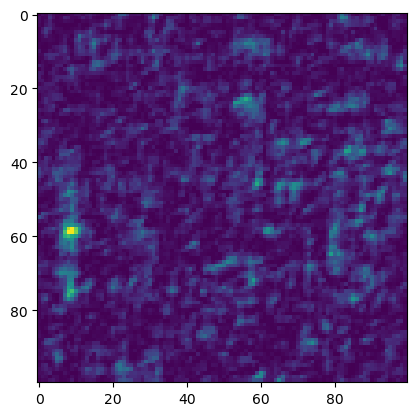